In [18]:
import os.path as osp
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

import fish_models

In [19]:
import robofish.io

# Data

In [3]:
raycast = fish_models.Raycast(
            n_fish_bins=150,
            n_wall_raycasts=150,
            fov_angle_fish_bins=2*np.pi,
            fov_angle_wall_raycasts=2*np.pi,
            world_bounds=([-50, -50], [50, 50]),
            view_of = ["fish", "fish_oris", "walls"]
        )

In [4]:
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\train"

dset = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\test"

dset_test = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\validation"

dset_val = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)

Loading data from 197 files.


100%|████████████████████████████████████████| 197/197 [00:07<00:00, 25.83it/s]


Calculating views from 197 files.


100%|████████████████████████████████████████| 197/197 [02:15<00:00,  1.45it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 32851.38it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 32796.61it/s]


Reducing shape of views.


100%|███████████████████████████████████████| 197/197 [00:00<00:00, 295.51it/s]


Status of IoDataset:
poses	(197, 8, 749, 3):	consisting of x, y, orientation.
actions	(197, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(197, 8, 749, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
Loading data from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:01<00:00, 18.86it/s]


Calculating views from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:21<00:00,  1.10it/s]


Reducing shape of poses.


100%|████████████████████████████████████████| 24/24 [00:00<00:00, 1107.77it/s]


Reducing shape of actions.


100%|████████████████████████████████████████| 24/24 [00:00<00:00, 2662.84it/s]


Reducing shape of views.


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 195.22it/s]


Status of IoDataset:
poses	(24, 8, 749, 3):	consisting of x, y, orientation.
actions	(24, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(24, 8, 749, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
Loading data from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:01<00:00, 17.68it/s]


Calculating views from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:17<00:00,  1.36it/s]


Reducing shape of poses.


100%|████████████████████████████████████████| 24/24 [00:00<00:00, 8005.03it/s]


Reducing shape of actions.


100%|███████████████████████████████████████| 24/24 [00:00<00:00, 12006.60it/s]


Reducing shape of views.


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 258.21it/s]


Status of IoDataset:
poses	(24, 8, 749, 3):	consisting of x, y, orientation.
actions	(24, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(24, 8, 749, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them


In [6]:
more_than_2_mask = (~np.isnan(dset["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) == 2
more_than_2_mask_test = (~np.isnan(dset_test["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) == 2
more_than_2_mask_val = (~np.isnan(dset_val["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) == 2
more_than_2_mask.shape, more_than_2_mask.sum(), more_than_2_mask_test.shape, more_than_2_mask_test.sum(), more_than_2_mask_val.shape, more_than_2_mask_val.sum()

((197,), 49, (24,), 7, (24,), 4)

In [7]:
swarm_poses = dset["poses"][more_than_2_mask]
swarm_actions = dset["actions"][more_than_2_mask]
swarm_views = dset["views"][more_than_2_mask]
swarm_poses.shape, swarm_actions.shape, swarm_views.shape

((49, 8, 749, 3), (49, 8, 749, 2), (49, 8, 749, 450))

In [8]:
arrrr = np.round(swarm_actions[:,:,:,0].flatten()[~np.isnan(swarm_actions[:,:,:,0].flatten())])
arrrr.min(), arrrr.mean(), arrrr.max()

(8.0, 8.0, 8.0)

## Position Prediction Dataset

In [9]:
data_list = []
for graph_time in swarm_poses:
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    #print(edge_index)
    for graph1, graph2 in zip(graph_time_nonna[:-1], graph_time_nonna[1:]):
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(graph2, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
#data_list = [Data(...), ..., Data(...)]
random.seed(5543)
random.shuffle(data_list)

# Once it's shuffled, we slice the data to split
test_len = int(len(data_list) // (1/0.3))
print(test_len)
train_dataset = data_list[test_len:]
test_dataset = data_list[:test_len]
train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

10995


## Action Prediction Dataset

In [10]:
data_list = []
for graph_time, graph_action in zip(swarm_poses, swarm_actions):
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    #print(edge_index)
    for graph1, label1 in zip(graph_time_nonna, graph_action_nonna):
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(label1[:,1], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

train2_loader = DataLoader(data_list, batch_size=256)

In [11]:
swarm_poses_test = dset_test["poses"][more_than_2_mask_test]
swarm_actions_test = dset_test["actions"][more_than_2_mask_test]
swarm_views_test = dset_test["views"][more_than_2_mask_test]
swarm_poses_test.shape, swarm_actions_test.shape, swarm_views_test.shape

((7, 8, 749, 3), (7, 8, 749, 2), (7, 8, 749, 450))

In [12]:
data_list = []
for graph_time, graph_action in zip(swarm_poses_test, swarm_actions_test):
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    #print(edge_index)
    for graph1, label1 in zip(graph_time_nonna, graph_action_nonna):
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(label1[:,1], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

test2_loader = DataLoader(data_list, batch_size=256)

In [13]:
swarm_poses_val = dset_val["poses"][more_than_2_mask_val]
swarm_actions_val = dset_val["actions"][more_than_2_mask_val]
swarm_views_val = dset_val["views"][more_than_2_mask_val]
swarm_poses_val.shape, swarm_actions_val.shape, swarm_views_val.shape

((4, 8, 749, 3), (4, 8, 749, 2), (4, 8, 749, 450))

In [28]:
data_list = []
for graph_time, graph_action in zip(swarm_poses_val, swarm_actions_val):
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    #print(edge_index)
    for graph1, label1 in zip(graph_time_nonna, graph_action_nonna):
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(label1[:,1], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)

val2_loader = DataLoader(data_list, batch_size=256)

## Action Prediction Dataset with edges only between fish in the zone of attraction

In [15]:
data_list = []
for graph_time, graph_action in zip(swarm_poses, swarm_actions):
    graph_time_nonna = graph_time[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_time)).any(axis=-1).any(axis=-1)]
    graph_time_nonna = np.swapaxes(graph_time_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    num_nodes = graph_time_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    
        
    for graph1, label1 in zip(graph_time_nonna, graph_action_nonna):
        
        filt = torch.arange(edge_index.shape[1]) == torch.arange(edge_index.shape[1])
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i == j:
                    continue
                if np.linalg.norm(graph1[i,:2]-graph1[j,:2]) > 40:
                    if i > j:
                        filt = filt & (torch.arange(edge_index.shape[1])!=i*(num_nodes-1) + (j)) & (torch.arange(edge_index.shape[1])!=j*(num_nodes-1) + (i-1))
                    else:
                        filt = filt & (torch.arange(edge_index.shape[1])!=i*(num_nodes-1) + (j-1)) & (torch.arange(edge_index.shape[1])!=j*(num_nodes-1) + (i))
        filt_edge_index = edge_index[:,filt]
        x = torch.tensor(graph1, dtype=torch.float)
        y = torch.tensor(label1[:,1], dtype=torch.float)
        data = Data(x=x, edge_index=filt_edge_index, y=y)
        data_list.append(data)
#data_list = [Data(...), ..., Data(...)]
random.seed(5543)
random.shuffle(data_list)

# Once it's shuffled, we slice the data to split
test_len = int(len(data_list) // (1/0.3))
print(test_len)
train3_dataset = data_list[test_len:]
test3_dataset = data_list[:test_len]
train3_loader = DataLoader(train3_dataset, batch_size=64)
test3_loader = DataLoader(test3_dataset, batch_size=64)

11010


# Model

In [16]:
from torch_geometric.nn import GraphConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv

In [12]:
# class EncodingSwarmNet(nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super().__init__()
#         torch.manual_seed(42)
#         self.gconv1 = GraphConv(in_channels, hidden_channels)
#         self.predictor = nn.Linear(hidden_channels, out_channels)

#     def forward(self, x, edge_index):
#         x = self.gconv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.predictor(x)
#         return x

In [17]:
class EncodingSwarmNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        torch.manual_seed(42)
        self.encoder1 = nn.Linear(in_channels, hidden_channels//4)
        self.encoder2 = nn.Linear(hidden_channels//4, hidden_channels//2)
        self.gconv1 = GraphConv(hidden_channels//2, hidden_channels)
        self.linear1 = nn.Linear(hidden_channels, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, hidden_channels)
        self.linear3 = nn.Linear(hidden_channels, hidden_channels)
        self.predictor = nn.Linear(hidden_channels, out_channels)
        self.lrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, edge_index):
        x = self.dropout(self.lrelu(self.encoder1(x)))
        x = self.dropout(self.lrelu(self.encoder2(x)))
        x = self.dropout(self.lrelu(self.gconv1(x, edge_index)))
        x = self.dropout(self.lrelu(self.linear1(x)))
        x = self.dropout(self.lrelu(self.linear3(x)))
        x = self.dropout(self.lrelu(self.linear3(x)))
        x = self.predictor(x)
        return x

# Training with turn label

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EncodingSwarmNet(3, 640, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.MSELoss()

def train(epoch):
    model.train()
    for data in train2_loader:
        data = data.to(device)
        optimizer.zero_grad()
        criterion(model(data.x, data.edge_index), data.y.reshape((-1,1))).backward()
        optimizer.step()


def test(loader):
    model.eval()
    mse = 0

    for data in loader:
        data = data.to(device)
        mse += criterion(model(data.x, data.edge_index), data.y.reshape((-1,1))).item()
    return mse / len(test_dataset)

train2_losses = []
val2_losses = []
prev_min = np.inf
counter = 0
for epoch in range(1, 5000):
    train(epoch)
    train_loss = test(train2_loader)
    val_loss = test(val2_loader)
    train2_losses.append(train_loss)
    val2_losses.append(val_loss)
    if val_loss < prev_min:
        prev_min = val_loss
        counter = 0
    else:
        counter += 1
    if counter == 30:
        print("Early stopping!")
        break
    print(f'Epoch: {epoch:03d}, Train: {train_loss:.6f}, Val: {val_loss:.6f}, Stopping Counter: {counter+1}/30')

Epoch: 001, Train: 0.005577, Val: 0.000506, Stopping Counter: 1/30
Epoch: 002, Train: 0.005534, Val: 0.000508, Stopping Counter: 2/30
Epoch: 003, Train: 0.005505, Val: 0.000509, Stopping Counter: 3/30
Epoch: 004, Train: 0.005482, Val: 0.000510, Stopping Counter: 4/30
Epoch: 005, Train: 0.005464, Val: 0.000511, Stopping Counter: 5/30
Epoch: 006, Train: 0.005447, Val: 0.000511, Stopping Counter: 6/30
Epoch: 007, Train: 0.005432, Val: 0.000510, Stopping Counter: 7/30
Epoch: 008, Train: 0.005417, Val: 0.000510, Stopping Counter: 8/30
Epoch: 009, Train: 0.005402, Val: 0.000510, Stopping Counter: 9/30
Epoch: 010, Train: 0.005389, Val: 0.000510, Stopping Counter: 10/30
Epoch: 011, Train: 0.005375, Val: 0.000510, Stopping Counter: 11/30
Epoch: 012, Train: 0.005361, Val: 0.000509, Stopping Counter: 12/30
Epoch: 013, Train: 0.005348, Val: 0.000508, Stopping Counter: 13/30
Epoch: 014, Train: 0.005333, Val: 0.000508, Stopping Counter: 14/30
Epoch: 015, Train: 0.005321, Val: 0.000508, Stopping Coun

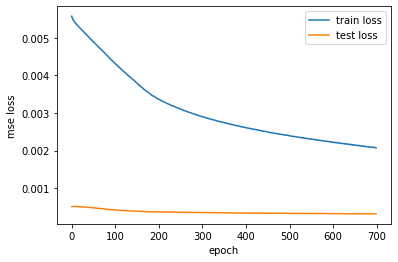

In [30]:
plt.plot(train2_losses, label="train loss")
plt.plot(val2_losses, label="test loss")
plt.xlabel("epoch")
plt.ylabel("mse loss")
plt.legend()
plt.show()

## Save Checkpoint

In [31]:
PATH = "turn_label_large_model.pt"

In [32]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train2_losses[-1],
            'val_loss': val2_losses[-1],
            }, PATH)

## Load Checkpoint

In [ ]:
model = EncodingSwarmNet(3, 640, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
prev_train_loss = checkpoint['train_loss']
prev_val_loss = checkpoint['val_loss']

model.eval()

# Build Fish Model from Torch Model

In [33]:
class CouzinModel(fish_models.AbstractModel):
    def __init__(self, regressor):
        #self.raycast = raycast
        self.regressor = regressor

    def choose_action(self, poses_3d, self_id):
        speed = 8
        num_nodes = poses_3d.shape[0]
        list2 = []
        list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
        for k in range(num_nodes):
            list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
        list2 = np.concatenate(list2)
        start = torch.tensor(swarm_poses[counter,:, 0][(~np.isnan(swarm_poses[counter])).any(axis=-1).any(axis=-1)],
                             dtype=torch.float)
        edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
        x_input = torch.tensor(poses_3d, dtype=torch.float)
        turn = self.regressor(x_input, edge_index).detach().numpy()[self_id].item()
        return speed, turn

100%|███████████████████████████████████████| 748/748 [00:02<00:00, 266.73it/s]


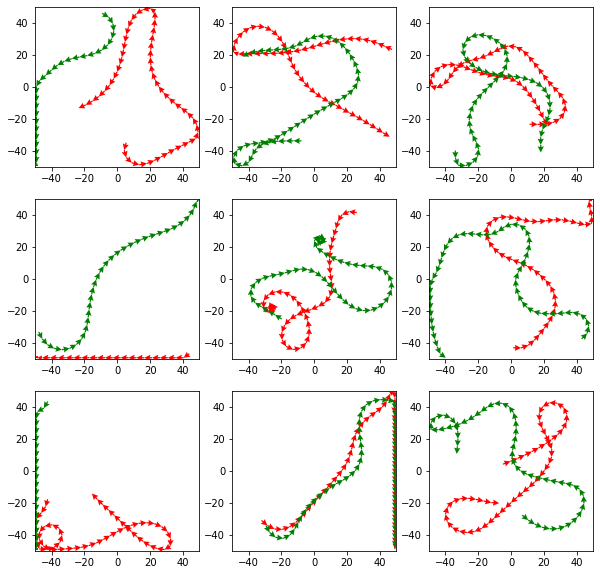

In [34]:
with torch.no_grad():
    model.eval()
    model.to("cpu")
    raymodel = CouzinModel(model)
    generator = fish_models.TrackGeneratorGym([raymodel], world_size=[100,100], frequency=25)
colour_list = ["r", "g", "b", "y", "black"]
n = 2
fig, axs = plt.subplots(3,3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
        for fish_id in range(n):
            a = track[fish_id, ::15, 0]
            b = track[fish_id, ::15, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', 
                            scale=1, headwidth=5, color = colour_list[fish_id])
            #axs[i,j].plot(track[fish_id, :, 0], track[fish_id, :, 1], label=fish_id)
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
plt.show()

100%|███████████████████████████████████████| 748/748 [00:02<00:00, 291.03it/s]


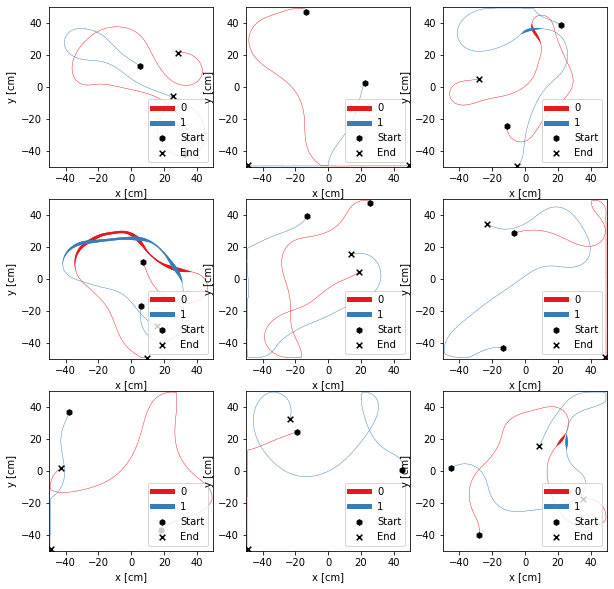

In [35]:
fig, axs = plt.subplots(3,3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
        f = generator.as_io_file(track)
        f.plot(lw_distances=True, ax=axs[i,j])
plt.show()

# Overarching Evaluation

In [37]:
paths = []
labels = []
model_path = r"D:\ResearchInternshipData\turn_label_large_model"
model_label = "Model Data"
for i in range(50):
    track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
    filename = r"D:\ResearchInternshipData\turn_label_large_model\track_" + str(i+1) + ".hdf5"
    f = generator.as_io_file(track, filename)
    paths.append(filename)
    labels.append("track_" + str(i+1))
f.close() 

100%|███████████████████████████████████████| 748/748 [00:02<00:00, 294.16it/s]


In [38]:
import robofish.evaluate.evaluate as robo_eval

In [39]:
f1 = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\test"

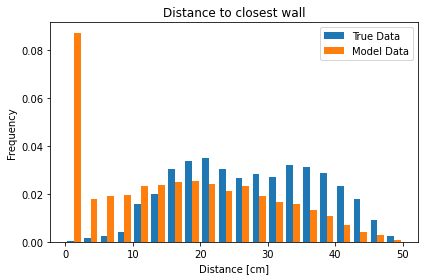

In [43]:
robo_eval.evaluate_distanceToWall([f1, model_path], ["True Data", model_label])
plt.show()

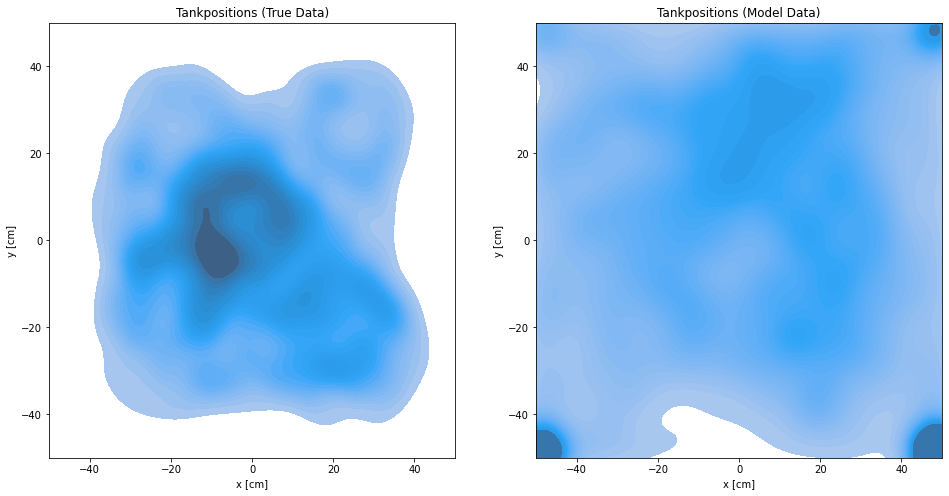

In [44]:
robo_eval.evaluate_tankpositions([f1,model_path], ["True Data",model_label])
plt.show()

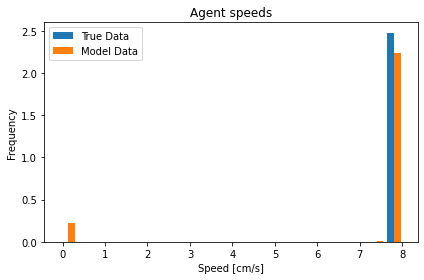

In [45]:
robo_eval.evaluate_speed([f1, model_path], ["True Data", model_label])
plt.show()

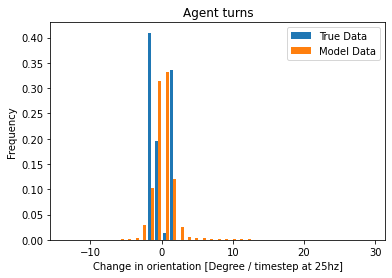

In [46]:
robo_eval.evaluate_turn([f1,model_path], ["True Data",model_label])
plt.show()

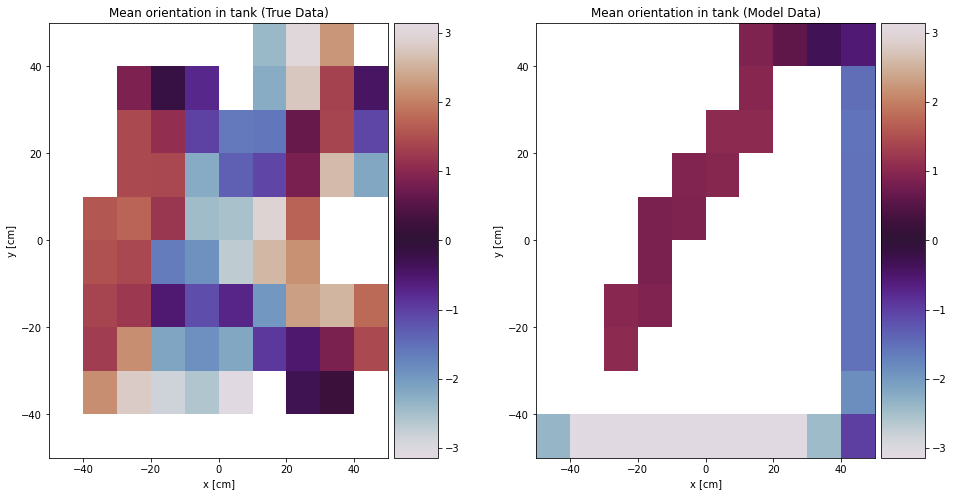

In [47]:
robo_eval.evaluate_orientation([f1, model_path], ["True Data", model_label])
plt.show()

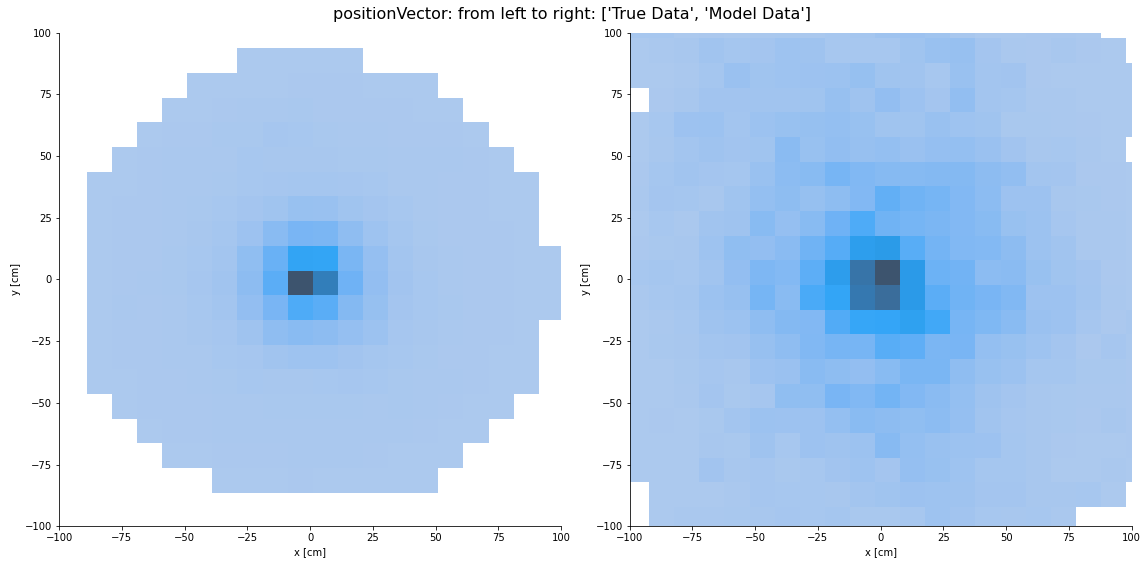

In [53]:
robo_eval.evaluate_positionVec([f1, model_path], ["True Data", model_label])
plt.tight_layout()
plt.show()

<Figure size 576x576 with 0 Axes>

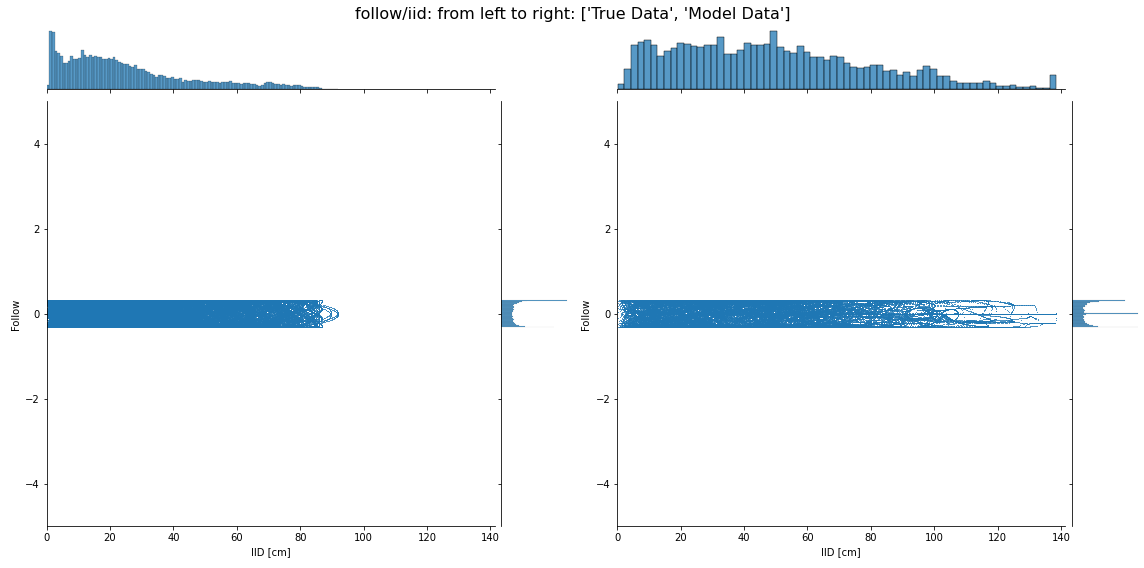

In [54]:
plt.figure(figsize=(8,8))
robo_eval.evaluate_follow_iid([f1, model_path], ["True Data", model_label])
plt.tight_layout()
plt.show()